# Histological Validation of Mouse Spleen Structures

## Loading Packages

In [7]:
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
import matplotlib.pyplot as plt

import numpy as np

## Removing Background

In [2]:
def remove_background(image_path):
    # Open the image file
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image at {image_path}")
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    height, width, _ = image.shape

    # Calculate the start and end coordinates for the cropping area
    start_x = int(width * 0.15)  # Start at 15% of the width
    start_y = int(height * 0.08)  # Start at 8% of the height
    end_x = int(width * 0.9)  # End at 90% of the width
    end_y = int(height * 0.85)  # End at 85% of the height

    # Crop the middle 60% of the image
    image = image[start_y:end_y, start_x:end_x]
    
    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(image, (21, 21), 0)

    # Convert the blurred image to grayscale
    gray_blurred_image = cv2.cvtColor(blurred_image, cv2.COLOR_RGB2GRAY)

    # Perform binary thresholding
    _, binary_image = cv2.threshold(gray_blurred_image, 200, 255, cv2.THRESH_BINARY)

    # Find connected components and their statistics
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)

    # Find the largest connected component
    max_area = 0
    max_label = 0
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] > max_area:
            max_area = stats[i, cv2.CC_STAT_AREA]
            max_label = i

    # Create a mask to remove the largest connected component (white area)
    mask = np.ones_like(binary_image) * 255  # Ensure the mask is a single-channel 8-bit image
    mask[labels == max_label] = 0

    # Create an image with an alpha channel
    image_with_alpha = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
    image_with_alpha[:, :, 0:3] = image  # Copy RGB values

    # Apply the mask to the alpha channel
    image_with_alpha[:, :, 3] = mask  # Set black areas to transparent and others to opaque

    return image_with_alpha

Histological Image of replicate 1:


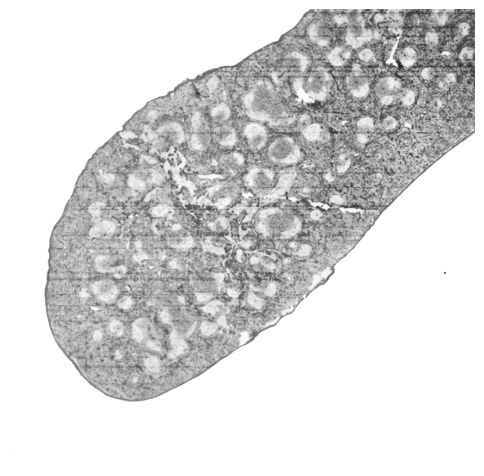

Histological Image of replicate 2:


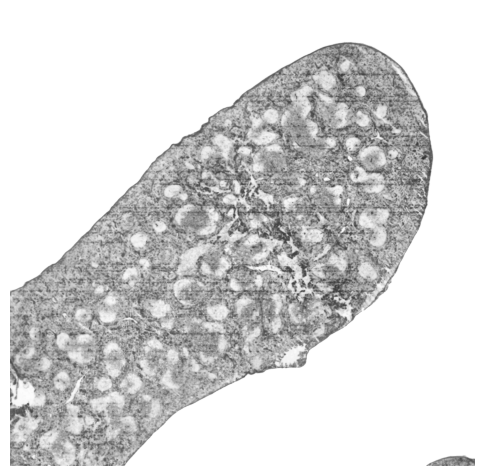

In [3]:
# List of replicate numbers
replicate_num = ['1', '2']

# Generate the list of image paths
image_paths = [f"../../../Data/Mouse_Spleen_{num}/spatial/tissue_hires_image.png" for num in replicate_num]

# Process each image and display/save the results
for i, image_path in enumerate(image_paths):
    result_image = remove_background(image_path)
    if result_image is not None:
        print(f"Histological Image of replicate {i+1}:")
        # Display the result image
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGRA2RGBA))
        plt.title(f"")
        plt.axis('off')  # Do not display the axis
        plt.savefig(f"./replicate{i+1}/Histological_Image.png", dpi=500, bbox_inches='tight')
        plt.savefig(f"./replicate{i+1}/Histological_Image.eps", bbox_inches='tight')
        plt.show()

# Visualizing Germinal Centers

In [22]:
def find_GCs(image_path, GCs_color=[238, 85, 96, 255]):
    # Open the image file
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image at {image_path}")
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get the height and width of the image
    height, width, _ = image.shape

    # Calculate the start and end coordinates for the cropping area
    start_x = int(width * 0.15)  # Start at 15% of the width
    start_y = int(height * 0.08)  # Start at 8% of the height
    end_x = int(width * 0.9)  # End at 90% of the width
    end_y = int(height * 0.85)  # End at 85% of the height

    # Crop the middle 80% of the image
    image = image[start_y:end_y, start_x:end_x]

    image = cv2.GaussianBlur(image, (51, 51), 0)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Perform binary thresholding; the threshold value can be adjusted according to the actual situation
    _, binary_image = cv2.threshold(gray_image, 185, 255, cv2.THRESH_BINARY)

    # Create a black image of the same size as the original image for drawing the binary red and blue regions, and add an alpha channel
    result_image = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)

    # Set the transparency of red and blue, ranging from 0 to 255, with higher values being less transparent
    red_alpha = 255  # Transparency of red
    blue_alpha = 0  # Transparency of blue
    ## BGR
    result_image[binary_image == 255] = GCs_color
    result_image[binary_image == 0] = [0, 120, 120, blue_alpha]  # Blue

    # Find the connected regions of the red area
    red_mask = result_image[:, :, 0] > 0  # Mask for the red area
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(red_mask.astype(np.uint8), connectivity=8)

    # Find the largest connected region (excluding the background)
    max_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])  # The background label is 0, so start from 1 to find the maximum value

    # Set the largest connected region to transparent
    result_image[labels == max_label] = [0, 0, 0, 0]

    return result_image

GCs of replicate 1-red:


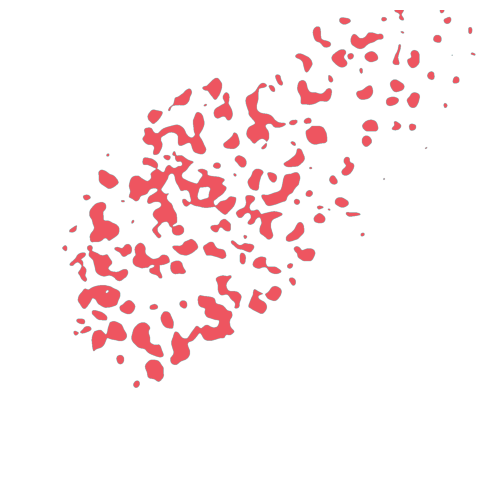

GCs of replicate 1-gray:


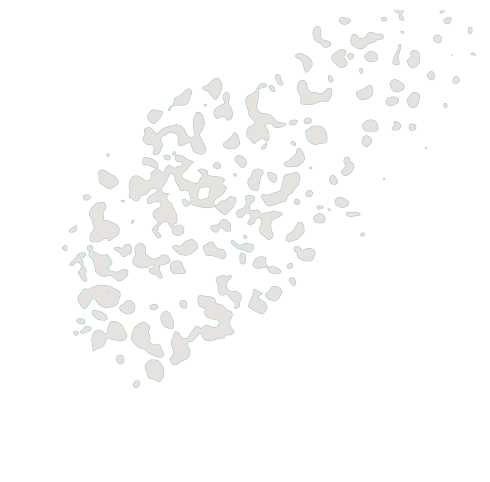

GCs of replicate 2-red:


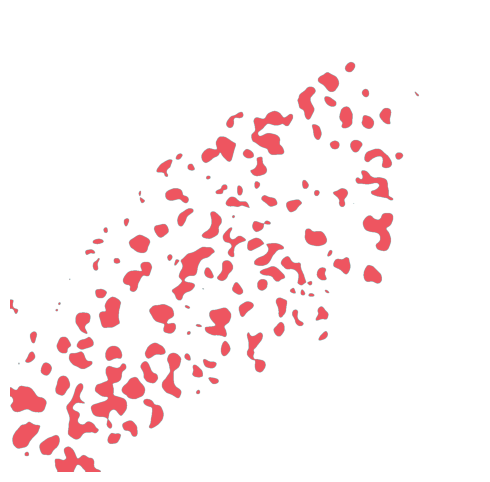

GCs of replicate 2-gray:


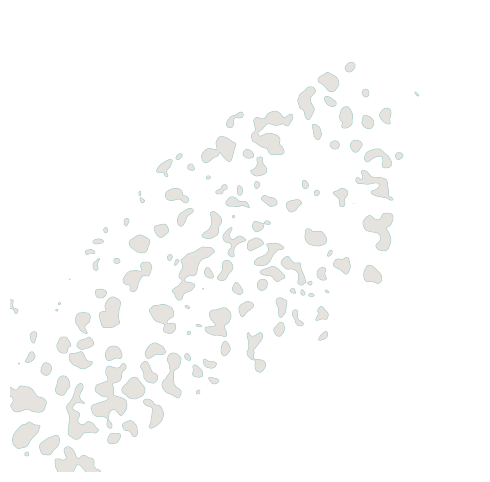

In [ ]:
# Color configuration dictionary (key is color name, value is RGB tuple)
color_configs = {
    "red":  [238, 85, 96, 255],
    "gray": [230, 226, 222, 255]
}

replicate_num = ['1', '2']
image_paths = [f"../../../Data/Mouse_Spleen_{num}/spatial/tissue_hires_image.png" 
               for num in replicate_num]

for i, image_path in enumerate(image_paths, start=1):
    for color_name, bg_color in color_configs.items():
        result_img = find_GCs(image_path, bg_color)
        print(f"GCs of replicate {i}-{color_name}:")
        if result_img is not None:
            # Create output directory (if it doesn't exist)
            output_dir = f"./replicate{i}/"
            os.makedirs(output_dir, exist_ok=True)
            
            # Generate filename with color name
            filename = f"GCs_{color_name}"
            plt.figure(figsize=(10, 6))
            plt.imshow(result_img)
            plt.axis('off')
            
            plt.savefig(f"{output_dir}/{filename}.png", dpi=500, bbox_inches='tight')
            plt.savefig(f"{output_dir}/{filename}.eps", bbox_inches='tight')
            plt.show()

## Visualizing Tissue Mask

In [26]:
def tissue_mask(image_path, background_color=[81, 192, 180]):
    # Open the image file
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image at {image_path}")
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Crop the image
    height, width, _ = image.shape
    start_x = int(width * 0.15)
    start_y = int(height * 0.08)
    end_x = int(width * 0.9)
    end_y = int(height * 0.85)
    image = image[start_y:end_y, start_x:end_x]

    # Image processing workflow
    image = cv2.GaussianBlur(image, (51, 51), 0)
    gray_blurred_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, binary_image = cv2.threshold(gray_blurred_image, 220, 255, cv2.THRESH_BINARY)
    
    # Connected component analysis
    binary_image_rgb = np.stack((binary_image,) * 3, axis=-1)
    binary_image_rgb[binary_image == 255] = [255, 255, 255]
    binary_image_rgb[binary_image == 0] = [0, 0, 255]
    
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, 8)
    max_label = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
    
    # Apply dynamic background color
    mask = np.zeros_like(binary_image, dtype=np.uint8)
    mask[labels == max_label] = 255
    result_image = binary_image_rgb.copy()
    result_image[mask == 0] = background_color  # Use the background color parameter passed in
    
    result_image = cv2.flip(result_image, 1)
    return result_image

tissue mask of replicate 1-blue:


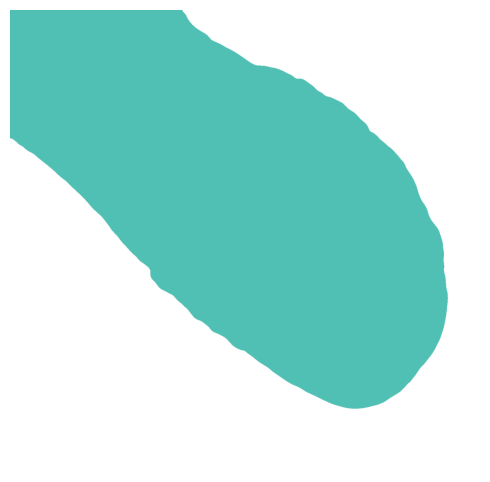

tissue mask of replicate 1-gray:


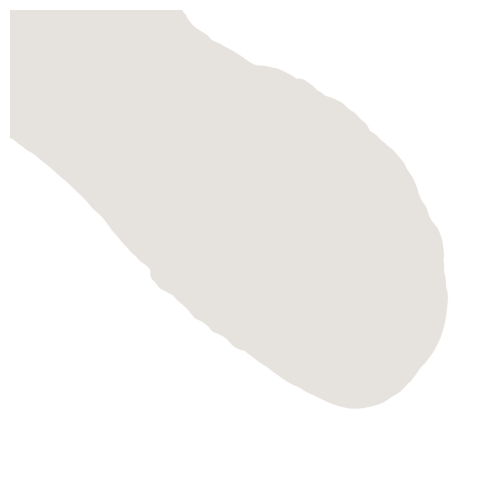

tissue mask of replicate 2-blue:


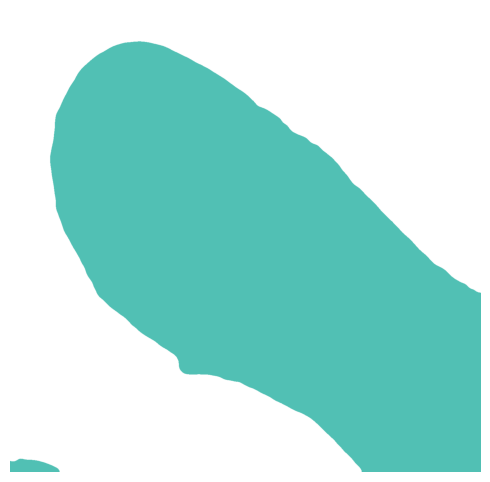

tissue mask of replicate 2-gray:


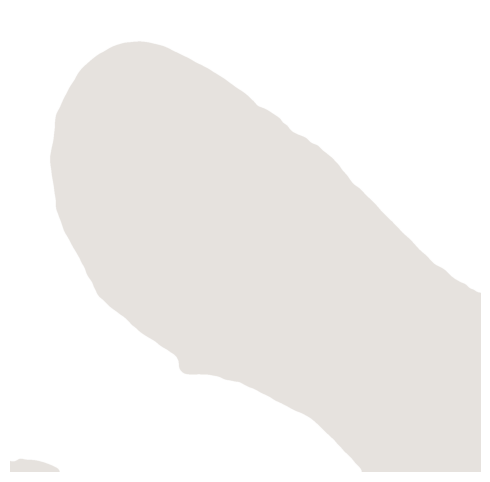

In [ ]:
# Color configuration dictionary (key is color name, value is RGB tuple)
color_configs = {
    "blue": (81, 192, 180),
    "gray": (230, 226, 222)
}

replicate_num = ['1', '2']
image_paths = [f"../../../Data/Mouse_Spleen_{num}/spatial/tissue_hires_image.png" 
               for num in replicate_num]

for i, image_path in enumerate(image_paths, start=1):
    for color_name, bg_color in color_configs.items():
        result_img = tissue_mask(image_path, bg_color)
        print(f"tissue mask of replicate {i}-{color_name}:")
        if result_img is not None:
            # Create output directory (if it doesn't exist)
            output_dir = f"./replicate{i}"
            os.makedirs(output_dir, exist_ok=True)
            
            # Generate filename with color name
            filename = f"tissue_mask_{color_name}"
            plt.figure(figsize=(10, 6))
            plt.imshow(result_img)
            plt.axis('off')
            
            plt.savefig(f"{output_dir}/{filename}.png", dpi=500, bbox_inches='tight')
            plt.savefig(f"{output_dir}/{filename}.eps", bbox_inches='tight')
            plt.show()